In [1]:
# hddm
import hddm
import kabuki
import pymc

# design matrix
from patsy import dmatrix

# data analysis
import pandas as pd
import numpy as np

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
#import ptitprince as pt

# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

# rmANOVA
from statsmodels.stats.anova import AnovaRM

# search file
import glob

# system
import os,sys,time

/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = '/home/jovyan/work/scripts'
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from InferenceDataFromHDDM import InferenceDataFromHDDM
from plot_ppc_by_cond import plot_ppc_by_cond

In [4]:
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current Kabuki version is', kabuki.__version__) # 0.6.3
print('The current PyMC version is', pymc.__version__) # 2.3.8
print('The current Numpy version is', np.__version__) 
print('The current Pandas version is', pd.__version__)
print('The current seaborn version is', sns.__version__)

The current HDDM version is 0.8.0
The current Kabuki version is 0.6.4
The current PyMC version is 2.3.8
The current Numpy version is 1.20.3
The current Pandas version is 1.3.5
The current seaborn version is 0.11.2


In [11]:
!pip install pandas


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


# Experiment Design

It is a car-face discrimination task in a 2* 2  factorial within-subject design. 

Experimental factors **"stimulus coherence”(with level "low" and "high")** and **"spatial prioritization"(with level "yes" and "no")**.

Experimental manipulation has four levels:




|level|coherence|prioritization|
| -------- | -------- | -------- |
|1|high|yes|
|2|high|no|
|3|low|yes|
|4|low|no|


![Image Name](https://cdn.kesci.com/upload/image/rmm71hlded.png?imageView2/0/w/960/h/960)


we assume that the effect of experimental design is reflected in underlying latent variable. 

Different levels corresponds to different parameters.

For the moment, we assume **phase coherence** can influence **drift rate(v)** and **spatial priotiziation** can influence **initial bias(z)**.

Because phase coherence have two levels(high & low) and spatial priotization(yes & no) have two levels, we have four levels together.

# Situation1

## Simulate data for the experiment

Because we need to code the response according to the stimulus, so we must transform the varibale 'stimulus'.

We assume that stimulus influence the parameter 'z'.

Due to the response is pressing 'car' or 'face', instead of accuracy coding, we set the stimulus(button press) as the boundaries.

So, when there are some bias, one stimulus is ``z``, another is ``1-z``.

In [24]:
# set the random seed
np.random.seed(123)

# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 20
trials_per_level = 72

# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':.8, 'a':2, 't':.3, 'z':.8, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':.8, 'a':2, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':.2, 'a':2, 't':.3, 'z':.8, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':.2, 'a':2, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':.8, 'a':2, 't':.3, 'z':.2, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':.8, 'a':2, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':.2, 'a':2, 't':.3, 'z':.2, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':.2, 'a':2, 't':.3, 'z':.5, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

## check the data

we can check how many trials per condition.

In [42]:
data.groupby(['subj_idx','stimulus','condition','coherence','attention']).size()

subj_idx  stimulus  condition  coherence  attention
0         0.0       level1     1.0        1.0          72
                    level2     1.0        0.0          72
                    level3     0.0        1.0          72
                    level4     0.0        0.0          72
          1.0       level1     1.0        1.0          72
                                                       ..
19        0.0       level4     0.0        0.0          72
          1.0       level1     1.0        1.0          72
                    level2     1.0        0.0          72
                    level3     0.0        1.0          72
                    level4     0.0        0.0          72
Length: 160, dtype: int64

In [43]:
data.groupby(['stimulus','coherence','attention','response'])['rt'].agg(['size','mean','std']).head(20)

size      mean       std
stimulus coherence attention response                          
0.0      0.0       0.0       0.0        494  1.197994  0.681693
                             1.0        946  1.233243  0.771780
                   1.0       0.0        974  0.793781  0.665234
                             1.0        466  1.475633  0.773954
         1.0       0.0       0.0        206  1.059652  0.532577
                             1.0       1234  1.066180  0.627825
                   1.0       0.0        667  0.689168  0.535394
                             1.0        773  1.356814  0.651742
1.0      0.0       0.0       0.0        631  1.181282  0.761018
                             1.0        809  1.206190  0.777833
                   1.0       0.0        234  1.398436  0.807061
                             1.0       1206  0.719062  0.569091
         1.0       0.0       0.0        281  1.109687  0.748369
                             1.0       1159  1.093177  0.639770
                   1.0       0.0         67  1.303904  0.690100
                             1.0       1373  0.662359  0.501304

In [44]:
data.groupby(['response'])['rt'].agg(['size','mean','std'])

,size,mean,std
response,,,
0.0,3554,0.988948,0.713071
1.0,7966,1.034168,0.699816


In [45]:
data.groupby(['stimulus','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus response                          
0.0      0.0       2341  0.872668  0.652656
         1.0       3419  1.233921  0.711226
1.0      0.0       1213  1.213361  0.769203
         1.0       4547  0.883969  0.652052

In [46]:
data.groupby(['coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
coherence response                          
0.0       0.0       2333  1.044824  0.743842
          1.0       3427  1.078870  0.761310
1.0       0.0       1221  0.882184  0.637038
          1.0       4539  1.000417  0.647587

In [47]:
data.groupby(['attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
attention response                          
0.0       0.0       1612  1.158380  0.710262
          1.0       4148  1.139131  0.700125
1.0       0.0       1942  0.848308  0.684412
          1.0       3818  0.920134  0.681485

we can check the effect of the coherence

In [48]:
data.groupby(['stimulus','coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence response                          
0.0      0.0       0.0       1468  0.929804  0.697273
                   1.0       1412  1.313238  0.780596
         1.0       0.0        873  0.776591  0.557122
                   1.0       2007  1.178119  0.652501
1.0      0.0       0.0        865  1.240026  0.779272
                   1.0       2015  0.914638  0.702532
         1.0       0.0        348  1.147079  0.740528
                   1.0       2532  0.859562  0.607933

Also, we can check the effect of the attention

In [49]:
data.groupby(['stimulus','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus attention response                          
0.0      0.0       0.0        700  1.157282  0.644141
                   1.0       2180  1.138676  0.698728
         1.0       0.0       1641  0.751260  0.617739
                   1.0       1239  1.401503  0.702271
1.0      0.0       0.0        912  1.159222  0.757455
                   1.0       1968  1.139634  0.701846
         1.0       0.0        301  1.377394  0.782434
                   1.0       2579  0.688875  0.534719

## anova

In [50]:
# ANOVA
model_aovrm3way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)


                          Anova
                             F Value Num DF  Den DF Pr > F
----------------------------------------------------------
coherence                    47.3861 1.0000 19.0000 0.0000
attention                    54.1370 1.0000 19.0000 0.0000
stimulus                      8.4608 1.0000 19.0000 0.0090
coherence:attention           8.8058 1.0000 19.0000 0.0079
coherence:stimulus            6.2351 1.0000 19.0000 0.0219
attention:stimulus           21.3151 1.0000 19.0000 0.0002
coherence:attention:stimulus 21.5495 1.0000 19.0000 0.0002



In [51]:
# ANOVA
model_aovrm3way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    403.5718 1.0000 19.0000 0.0000
attention                     39.0544 1.0000 19.0000 0.0000
stimulus                      43.6144 1.0000 19.0000 0.0000
coherence:attention           18.4459 1.0000 19.0000 0.0004
coherence:stimulus             1.5630 1.0000 19.0000 0.2264
attention:stimulus           599.2115 1.0000 19.0000 0.0000
coherence:attention:stimulus  21.0467 1.0000 19.0000 0.0002



The parameter **v** for high coherence is 0.8;

the parameter **v** for low coherence is 0.2;

the parameter **z** for cue of stimulus 1 is 0.8 and of stimulus 0 is 0.2;

the parameter **z** for no cue is 0.5;

At the same time, we assume that the response is mapping into two stimulus, car or face.

### model1 

v~coherence,

z~prioritization

when we fit the data, we will face the ideal situation.

$v=\alpha_0 + \alpha_1*C(coherence)$

$v_{low}=\alpha_0 = 0.2$

$v_{high}=\alpha_0 + \alpha_1 = 0.8$


$z=\beta_0 + \beta_1*C(prioritization)$ + z_link_func

stim = 1

$z_{no}=1 - \beta_0 = 0.5$

$z_{yes}=1 - (\beta_0 + \beta_1) = 0.2$

stim = 0

$z_{no}=\beta_0 = 0.5$

$z_{yes}=\beta_0 + \beta_1 = 0.8$

We expect the parameter estimated is:

$\alpha_0 = 0.2, \alpha_1 = 0.6$

$\beta_0 = 0.5, \beta_1 = 0.3$

### model2

if we set $v~C(coherence)*C(prioritization), z~C(coherence)*C(prioritization)$.

$v=\alpha_0 + \alpha_1*C(coherence) + \alpha_2*C(prioritization) + \alpha_3*C(coherence)*C(priorization)$

$v_{low,yes}=\alpha_0 + \alpha_2 + = 0.2$

$v_{high,yes}=\alpha_0 + \alpha_1 + \alpha_2 + \alpha_3= 0.8$

$v_{low,no}=\alpha_0  = 0.2$

$v_{high,no}=\alpha_0 + \alpha_1 = 0.8$

$v=\beta_0 + \beta_1*C(coherence) + \beta_2*C(prioritization) + \beta_3*C(coherence)*C(priorization)$ + z_link_func

stim = 1

$z_{no,high}=1 - \beta_0 - \beta_1= 0.5$

$z_{yes,high}=1 - (\beta_0 + \beta_1 + \beta_2 +\beta_3) = 0.2$

$z_{no,low}=1 - \beta_0 = 0.5$

$z_{yes,low}=1 - (\beta_0 + \beta_2) = 0.2$

stim = 0

$z_{no,high}=\beta_0 + \beta_1 = 0.5$

$z_{yes,high}=\beta_0 + \beta_1 + \beta_2 + \beta_3 = 0.8$

$z_{no,low}=\beta_0 = 0.5$

$z_{yes,low}=\beta_0 + \beta_2 = 0.8$

We expect the parameter estimated is:

$\alpha_0 = 0.2, \alpha_1 = 0.6, \alpha_2 = 0, \alpha_3 = 0$

$\beta_0 = 0.5, \beta_2 = 0.3, \beta_1 = 0, \beta_3 = 0$

this is the link func. the function is to create the node of z,

for stimulus 0, the node of z is $\beta_0 + \beta_1*X$

for stimulus 1, the node of z is $1 - (\beta_0 + \beta_1*X)$

In [19]:
def z_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
    )
    # Apply z = (1 - x) to flip them along 0.5
    z_flip = np.subtract(stim, x.to_frame())
    # The above inverts those values we do not want to flip,
    # so invert them back
    z_flip[stim == 0] *= -1
    return z_flip

## Fit data

### model1 

In [20]:
v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
z_reg = {'model':'z~C(attention)','link_func':z_link_func}
reg_descr = [v_reg, z_reg]
m_reg = hddm.HDDMRegressor(data, reg_descr, include='z')

Adding these covariates:
['v_Intercept', 'v_C(coherence)[T.1.0]']
Adding these covariates:
['z_Intercept', 'z_C(attention)[T.1.0]']


because we construct a glm, so we can check the design matrix and parameters.

this is the parameters.

In [55]:
# hddm/models/hddm_regression.py/line 164
params=np.matrix(m_reg.model_descrs[1]['params'])
params

matrix([['z_Intercept', 'z_C(attention)[T.1.0]']], dtype='<U21')

this is the design matrixs.

In [56]:
# hddm/models/hddm_regression.py/line 154
design_matrix=dmatrix('C(attention)',
                data,
                return_type="dataframe",
                NA_action="raise")
design_matrix

,Intercept,C(attention)[T.1.0]
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
11515,1.0,0.0
11516,1.0,0.0
11517,1.0,0.0
11518,1.0,0.0


` hddm/models/hddm_regression.py/line 174`

`design_matrix.dot(params.T)`

the row and line is nx2 2x1

the result is $\beta_0 + \beta_1 * C(attention)$

Then the linear predictor need to be transformed via link function

```
def z_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
    )
    # Apply z = (1 - x) to flip them along 0.5
    z_flip = np.subtract(stim, x.to_frame())
    # The above inverts those values we do not want to flip,
    # so invert them back
    z_flip[stim == 0] *= -1
    return z_flip
```

In [57]:
np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stimulus.loc[data.index]},return_type='dataframe'))

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

for stimulus 0, the result is $\beta_0 + \beta_1*X$

for stimulus 1, the result is $1 - (\beta_0 + \beta_1*X)$

In [13]:
v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
z_reg = {'model':'z~C(attention)','link_func':lambda x:x}
reg_descr = [v_reg, z_reg]
m_reg = hddm.HDDMRegressor(data, reg_descr, include='z')
m_reg.find_starting_values()
m_reg.sample(2000,burn=1000)

Adding these covariates:
['v_Intercept', 'v_C(coherence)[T.1.0]']
Adding these covariates:
['z_Intercept', 'z_C(attention)[T.1.0]']


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Process ForkPoolWorker-14:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-15:
Process ForkPoolWorker-16:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-10:
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    se

  File "/opt/conda/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/pytho

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py", line 1030, in _partial_optimize
    minimize(opt, init_vals, method=minimizer, options=minimizer_kwargs)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 614, in minimize
    return _minimize_powell(fun, x0, args, callback, bounds, **options)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 3031, in _minimize_powell
    fval, x, direc1 = _linesearch_powell(func, x, direc1,
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 2762, in _linesearch_powell
    alpha_min, fret, _, _ = brent(myfunc, full_output=1, tol=tol)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 2364, in brent
    res = _minimize_scalar_brent(func, brack, args, **options)
  File "/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 2396, in _minimize_scalar_brent
    b

  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
KeyboardInterrupt
  File "/opt/conda/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
Keyboard

TypeError: object of type 'NoneType' has no len()

In [ ]:
m_reg.plot_posteriors()

### model2

the glm and link function is similiar to model1.

In [40]:
v_reg = {'model':'v~C(coherence)*C(attention)','link_func':lambda x:x}
z_reg = {'model':'z~C(coherence)*C(attention)','link_func':z_link_func}
reg_descr = [v_reg, z_reg]
m_reg2 = hddm.HDDMRegressor(data, reg_descr, include='z')
m_reg2.find_starting_values()
m_reg2.sample(2000,burn=1000)

NameError: name 'z_link_func' is not defined

In [ ]:
m_reg2.plot_posteriors()

### model3

In model3, we want to test if we use incorrect coding, the results of the model.

In [25]:
data_tmp = data
data_tmp.loc[(data_tmp['response']==1)&(data_tmp['stimulus']==0),'_response'] = 0 
data_tmp.loc[(data_tmp['response']==1)&(data_tmp['stimulus']==1),'_response'] = 1 
data_tmp.loc[(data_tmp['response']==0)&(data_tmp['stimulus']==0),'_response'] = 1
data_tmp.loc[(data_tmp['response']==0)&(data_tmp['stimulus']==1),'_response'] = 0
data_tmp['response'] = data_tmp['_response']

In [26]:
data_tmp

,rt,response,subj_idx,condition,stimulus,coherence,attention,_response
0,0.803506,1.0,14.0,level1,1.0,1.0,1.0,1.0
1,0.690506,1.0,14.0,level1,1.0,1.0,1.0,1.0
2,0.678506,1.0,14.0,level1,1.0,1.0,1.0,1.0
3,0.753506,1.0,14.0,level1,1.0,1.0,1.0,1.0
4,0.813506,1.0,14.0,level1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
283,0.851019,0.0,14.0,level4,0.0,0.0,0.0,0.0
284,0.500019,0.0,14.0,level4,0.0,0.0,0.0,0.0
285,0.799019,0.0,14.0,level4,0.0,0.0,0.0,0.0
286,1.246019,0.0,14.0,level4,0.0,0.0,0.0,0.0


we can check how many trials per condition.

In [ ]:
data_tmp.groupby(['subj_idx','stimulus','condition','coherence','attention']).size()

In [ ]:
data_tmp.groupby(['stimulus','coherence','attention','response'])['rt'].agg(['size','mean','std']).head(20)

In [ ]:
data_tmp.groupby(['response'])['rt'].agg(['size','mean','std'])

In [ ]:
data_tmp.groupby(['stimulus','response'])['rt'].agg(['size','mean','std'])

we can check the effect of the coherence

In [ ]:
data_tmp.groupby(['stimulus','coherence','response'])['rt'].agg(['size','mean','std'])

Also, we can check the effect of the attention

In [ ]:
data_tmp.groupby(['stimulus','attention','response'])['rt'].agg(['size','mean','std'])

In [ ]:
v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
z_reg = {'model':'z~C(attention)','link_func':z_link_func}
reg_descr = [v_reg, z_reg]
m_reg3 = hddm.HDDMRegressor(data_tmp, reg_descr, include='z')
m_reg3.find_starting_values()
m_reg3.sample(2000,burn=1000)

In [ ]:
m_reg3.plot_posteriors()

# Simulation2

## simulate the data

To advance the simulated data similar to our true data, we adjust the value of parameter, and construct the hierarchical structure of every subjects.

In this part, we assume that the prioritization affect the non-decision time

In [7]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 15
trials_per_level = 36

# set the group parameter
# intercept and slope of v
v_int = 2
v_coh = 1.2
v_sig1 = 0.6
v_sig2 = 0.6
# intercept and slope of t
t_int = 0.3
t_pri = 0.2
t_sig1 = 0.1
t_sig2 = 0.1
# intercept of a
a_int = 1.4
a_sig = 0.2
# intercept of z
z_int = 0.5
z_sig = 0.1

# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig1,[n_subjects,2])
t_pri_subj = np.random.normal(t_pri,t_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
for i in range(n_subjects):
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    t_yes = t_int_subj[i] + t_pri_subj[i]
    t_no = t_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter z
    z = z_int_subj[i]
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # add column stimulus
    data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
    data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = pd.Series(np.ones((len(data)))*i, index=data.index).astype('int64')

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    
    df = df.append(data)

In [117]:
# the stimulus coding
df.loc[(df['stimulus']==0)&(df['response']==0),'_response']=1
df.loc[(df['stimulus']==1)&(df['response']==1),'_response']=1
df.loc[(df['stimulus']==0)&(df['response']==1),'_response']=0
df.loc[(df['stimulus']==1)&(df['response']==0),'_response']=0

In [118]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention,_response
0,0.449424,1.0,0,level1,1.0,1.0,1.0,1.0
1,0.361424,1.0,0,level1,1.0,1.0,1.0,1.0
2,0.352424,1.0,0,level1,1.0,1.0,1.0,1.0
3,0.411424,1.0,0,level1,1.0,1.0,1.0,1.0
4,0.457424,1.0,0,level1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
283,0.697170,1.0,14,level4,0.0,0.0,0.0,0.0
284,0.335170,1.0,14,level4,0.0,0.0,0.0,0.0
285,0.646170,1.0,14,level4,0.0,0.0,0.0,0.0
286,1.094170,1.0,14,level4,0.0,0.0,0.0,0.0


## check the data

In [119]:
df.groupby(['response'])['rt'].agg(['size','mean','std'])

,size,mean,std
response,,,
0.0,294,0.639011,0.303972
1.0,4026,0.586506,0.271567


In [120]:
df.groupby(['_response'])['rt'].agg(['size','mean','std'])

,size,mean,std
_response,,,
0.0,2086,0.621648,0.277703
1.0,2234,0.560602,0.267558


In [121]:
df.groupby(['stimulus','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus response                          
0.0      0.0        184  0.632735  0.275378
         1.0       1976  0.620097  0.273307
1.0      0.0        110  0.649509  0.347679
         1.0       2050  0.554127  0.265959

In [122]:
df.groupby(['coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
coherence response                          
0.0       0.0        258  0.668861  0.309732
          1.0       1902  0.647771  0.329809
1.0       0.0         36  0.425089  0.124264
          1.0       2124  0.531644  0.189860

In [123]:
df.groupby(['attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
attention response                          
0.0       0.0        172  0.626374  0.312404
          1.0       1988  0.555476  0.261731
1.0       0.0        122  0.656828  0.292011
          1.0       2038  0.616775  0.277571

In [124]:
df.groupby(['stimulus','coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence response                          
0.0      0.0       0.0        157  0.669295  0.278199
                   1.0        923  0.688439  0.338757
         1.0       0.0         27  0.420147  0.119901
                   1.0       1053  0.560193  0.178798
1.0      0.0       0.0        101  0.668186  0.354702
                   1.0        979  0.609429  0.316565
         1.0       0.0          9  0.439914  0.143193
                   1.0       1071  0.503576  0.196213

In [125]:
df.groupby(['stimulus','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus attention response                          
0.0      0.0       0.0        122  0.603615  0.253180
                   1.0        958  0.564278  0.252289
         1.0       0.0         62  0.690036  0.308734
                   1.0       1018  0.672626  0.281902
1.0      0.0       0.0         50  0.681904  0.421742
                   1.0       1030  0.547288  0.270081
         1.0       0.0         60  0.622513  0.271978
                   1.0       1020  0.561033  0.261681

In [126]:
df.groupby(['stimulus','coherence','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence attention response                          
0.0      0.0       0.0       0.0         97  0.650403  0.257147
                             1.0        443  0.622945  0.308452
                   1.0       0.0         60  0.699838  0.309045
                             1.0        480  0.748884  0.354212
         1.0       0.0       0.0         25  0.422082  0.124490
                             1.0        515  0.513813  0.176563
                   1.0       0.0          2  0.395961  0.023873
                             1.0        538  0.604589  0.169561
1.0      0.0       0.0       0.0         46  0.707551  0.430068
                             1.0        494  0.607760  0.330069
                   1.0       0.0         55  0.635261  0.276465
                             1.0        485  0.611128  0.302523
         1.0       0.0       0.0          4  0.386958  0.068618
                             1.0        536  0.491556  0.182800
                   1.0       0.0          5  0.482279  0.180082
                             1.0        535  0.515619  0.208265

## visualize the data

### the barplot

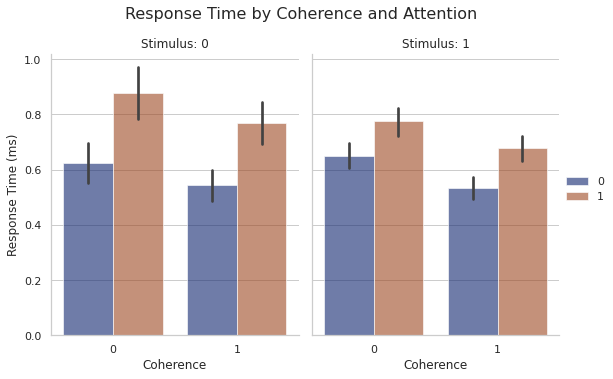

In [5]:
# get the mean of accurate RTs
data_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the figure theme
sns.set_theme(style="whitegrid")
# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

### the raincloud plot 

Text(0.5, 1, 'Response Time by Coherence and Attention')

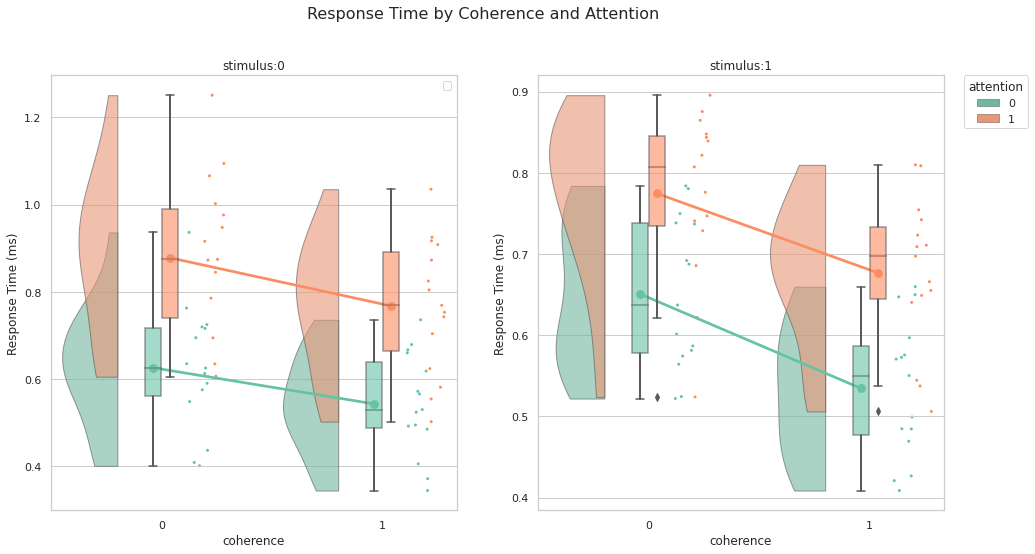

In [6]:
f, ax = plt.subplots(1,2,figsize=(16, 8))
# the left figure
ax[0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0].legend('')
ax[0].set_title('stimulus:0')
ax[0].set_ylabel('Response Time (ms)')
# the right figure
ax[1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1].set_title('stimulus:1')
ax[1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

## ANOVA

In [1]:
# ANOVA for rt
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

NameError: name 'AnovaRM' is not defined

## fit data

### define the model

In [4]:
 def ms1(id, df=None, samples=None, burn=None, thin=1,save_name='ms1'):
    '''
    id: the id of cpu thread
    df: the input data
    samples: number of samples for MCMC
    burn: number of burn-in of MCMC
    thin: number of thin
    save_name: prefix of file name when saving the model object
    '''
    print('running chain {:d} for model {}'.format(id, save_name))
    # the database file
    dbname = save_name + '_chain_%i.db'%id
    # the model object store here
    mname = save_name + '_chain_%i'%id
    # define the model
    v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
    t_reg = {'model':'t~C(attention)','link_func':lambda x:x}
    reg_descr = [v_reg, t_reg]
    m = hddm.HDDMRegressor(df, 
                           reg_descr, 
                           include='z',
                           #group_only_regressors=False,
                           #keep_regressor_trace=True
                          )
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save
    m.save(mname)

    return m

### judge whether need to sample

In [3]:
%%time
# number of chains
chains=4
# file name
file_names = glob.glob('ms1'+'_chain_*[!db]',recursive=False)
# if there exists file, pass
if file_names:
    # sort filename by id
    file_names = sorted(file_names, key = lambda x:x[-1])
    ms1res = []
    for fname in file_names:
        print('current loading:',fname,'\n')
        ms1res.append(hddm.load(fname))
# else sample
else:
    ms1res = Parallel(n_jobs = 4)(delayed(ms1)(id = i, df = df, samples=2000,burn = 1000,thin=1, save_name = 'ms1' ) for i in range(4))

current loading: ms1_chain_0 

current loading: ms1_chain_1 

current loading: ms1_chain_2 

current loading: ms1_chain_3 

CPU times: user 41.2 s, sys: 8.27 s, total: 49.5 s
Wall time: 49.7 s


In [ ]:
ms1res = Parallel(n_jobs = 4)(delayed(ms1)(id = i, df = df, samples=2000,burn = 1000,thin=1, save_name = 'ms1' ) for i in range(4))

### convert hddm model object to Inferencedata    

In [ ]:
%%time
InfData_ms1 = InferenceDataFromHDDM(ms1res, nppc = 300, save_name="infdata_ms1")

start converting infdata_ms1


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
%%time
file_names = glob.glob('infdata_ms1_netcdf',recursive=False)
if file_names:
    infdata_ms1 = az.from_netcdf('infdata_ms1_netcdf')
else:
    InfData_ms1 = InferenceDataFromHDDM(ms1res, nppc = 300, save_name="infdata_ms1")

## visualization

### plot traces

In [ ]:
az.plot_trace(InfData_ms1, var_names=("^v(?!.*(subj|std))"), filter_vars='regex')

In [ ]:
az.plot_trace(InfData_ms1, var_names=("^t(?!.*(subj|std))"), filter_vars='regex')

### summary data

In [ ]:
ms1_summary_tmp = az.summary(InfData_ms1, round_to=4)
ms1_summary_tmp.sort_values('r_hat')

### posterior predictive check

In [ ]:
az.plot_ppc(InfData_ms1,
            var_names=['rt','response'], 
            textsize=20, 
            num_pp_samples=300, 
            alpha = 0.2)

### Check dic, loo and waic

In [4]:
# dic
m1 = kabuki.utils.concat_models(ms1res)
m1.dic

In [ ]:
# loo
az.loo(InfData_ms1, scale="deviance")

In [ ]:
# waic
az.waic(InfData_ms1, scale="deviance")

### posterior predictive check by condition

In [ ]:
# coherence
plot_ppc_by_cond(data = InfData_ms1, 
                 or_d = df, 
                 subjs = [3], 
                 conds = ['coherence'], 
                 num_pp_samples=300, 
                 random_seed = 7, 
                 alpha = 0.2, 
                 grid = [2,2], 
                 textsize=20, 
                 var_names=['rt'])

In [ ]:
# attention
plot_ppc_by_cond(data = InfData_ms1, 
                 or_d = df, 
                 subjs = [3], 
                 conds = ['attention'], 
                 num_pp_samples=300, 
                 random_seed = 7, 
                 alpha = 0.2, 
                 grid = [2,2], 
                 textsize=20, 
                 var_names=['rt'])

## Statistical Inference

In [ ]:
# v_int
az.plot_posterior(InfData['ms1'], 
                  filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|Intercept))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=v_int)

In [ ]:
# v_coh
az.plot_posterior(InfData['ms1'], 
                  filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|coherence))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=v_coh)

In [ ]:
# t_int
az.plot_posterior(InfData['ms1'], 
                  filter_vars='regex', 
                  var_names=("^t_(?!.*(subj|std|Intercept))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=t_int)

In [ ]:
# t_coh
az.plot_posterior(InfData['ms1'], 
                  filter_vars='regex', 
                  var_names=("^t_(?!.*(subj|std|attention))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=t_pri)

# Simulation3

## simulate the data

In [5]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 15
trials_per_level = 36

# set the group parameter
# intercept and slope of v
v_int = 1.7
v_coh = 1.3
v_sig1 = 0.7
v_sig2 = 1
# intercept and slope of z
z_int = 0.5
z_pri = 0.1
z_sig1 = 0.1
z_sig2 = 0.1
# intercept of a
a_int = 1.4
a_sig = 0.2
# intercept of t
t_int = 0.36
t_sig = 0.02

# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig1,[n_subjects,2])
z_pri_subj = np.random.normal(z_pri,z_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
for i in range(n_subjects):
    
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    z_yes = z_int_subj[i] + z_pri_subj[i]
    z_no = z_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter t
    t = t_int_subj[i]
    
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # add column stimulus
    data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
    data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = pd.Series(np.ones((len(data)))*i, index=data.index).astype('int64')

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    
    df = df.append(data)

/tmp/ipykernel_14977/648444295.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_a.append(data_b,ignore_index=True)
/tmp/ipykernel_14977/648444295.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
/tmp/ipykernel_14977/648444295.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_a.append(data_b,ignore_index=True)
/tmp/ipykernel_14977/648444295.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
/tmp/ipykernel_14977/648444295.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

In [225]:
# the stimulus coding
df.loc[(df['stimulus']==0)&(df['response']==0),'_response']=1
df.loc[(df['stimulus']==1)&(df['response']==1),'_response']=1
df.loc[(df['stimulus']==0)&(df['response']==1),'_response']=0
df.loc[(df['stimulus']==1)&(df['response']==0),'_response']=0

## check the data

In [3]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.451293,1.0,0,level1,1.0,1.0,1.0
1,0.413293,1.0,0,level1,1.0,1.0,1.0
2,0.409293,1.0,0,level1,1.0,1.0,1.0
3,0.436293,1.0,0,level1,1.0,1.0,1.0
4,0.454293,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
283,0.828254,1.0,14,level4,0.0,0.0,0.0
284,0.585254,0.0,14,level4,0.0,0.0,0.0
285,0.761254,1.0,14,level4,0.0,0.0,0.0
286,1.352254,1.0,14,level4,0.0,0.0,0.0


In [227]:
df.groupby(['response'])['rt'].agg(['size','mean','std'])

,size,mean,std
response,,,
0.0,190,0.721680,0.306996
1.0,4130,0.584378,0.226664


In [228]:
df.groupby(['_response'])['rt'].agg(['size','mean','std'])

,size,mean,std
_response,,,
0.0,2080,0.593362,0.242053
1.0,2240,0.587681,0.223186


In [229]:
df.groupby(['stimulus','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus response                          
0.0      0.0        135  0.706890  0.276479
         1.0       2025  0.588891  0.236084
1.0      0.0         55  0.757983  0.371870
         1.0       2105  0.580036  0.217185

In [230]:
df.groupby(['coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
coherence response                          
0.0       0.0        170  0.738800  0.314895
          1.0       1990  0.641372  0.283246
1.0       0.0         20  0.576161  0.174925
          1.0       2140  0.531378  0.136894

In [231]:
df.groupby(['attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
attention response                          
0.0       0.0        133  0.718551  0.318602
          1.0       2027  0.615022  0.236716
1.0       0.0         57  0.728983  0.280603
          1.0       2103  0.554840  0.212446

In [232]:
df.groupby(['stimulus','coherence','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence response                          
0.0      0.0       0.0        115  0.729626  0.285012
                   1.0        965  0.643382  0.294279
         1.0       0.0         20  0.576161  0.174925
                   1.0       1060  0.539283  0.150079
1.0      0.0       0.0         55  0.757983  0.371870
                   1.0       1025  0.639480  0.272582
         1.0       1.0       1080  0.523619  0.122156

In [233]:
df.groupby(['stimulus','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus attention response                          
0.0      0.0       0.0        101  0.687934  0.264622
                   1.0        979  0.605007  0.235718
         1.0       0.0         34  0.763201  0.306321
                   1.0       1046  0.573807  0.235542
1.0      0.0       0.0         32  0.815184  0.440050
                   1.0       1048  0.624378  0.237376
         1.0       0.0         23  0.678400  0.234928
                   1.0       1057  0.536071  0.185009

In [234]:
df.groupby(['stimulus','coherence','attention','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherence attention response                          
0.0      0.0       0.0       0.0         81  0.715532  0.276350
                             1.0        459  0.655849  0.284361
                   1.0       0.0         34  0.763201  0.306321
                             1.0        506  0.632073  0.302832
         1.0       0.0       0.0         20  0.576161  0.174925
                             1.0        520  0.560130  0.170414
                   1.0       1.0        540  0.519209  0.124366
1.0      0.0       0.0       0.0         32  0.815184  0.440050
                             1.0        508  0.694513  0.296397
                   1.0       0.0         23  0.678400  0.234928
                             1.0        517  0.585405  0.234989
         1.0       0.0       1.0        540  0.558399  0.133496
                   1.0       1.0        540  0.488840  0.098117

## visualize the data

### the barplot

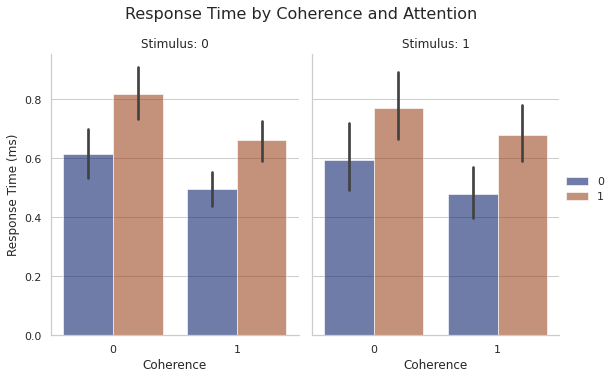

In [7]:
# get the mean of accurate RTs
data_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the figure theme
sns.set_theme(style="whitegrid")
# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

### the raincloud plot 

Text(0.5, 1, 'Response Time by Coherence and Attention')

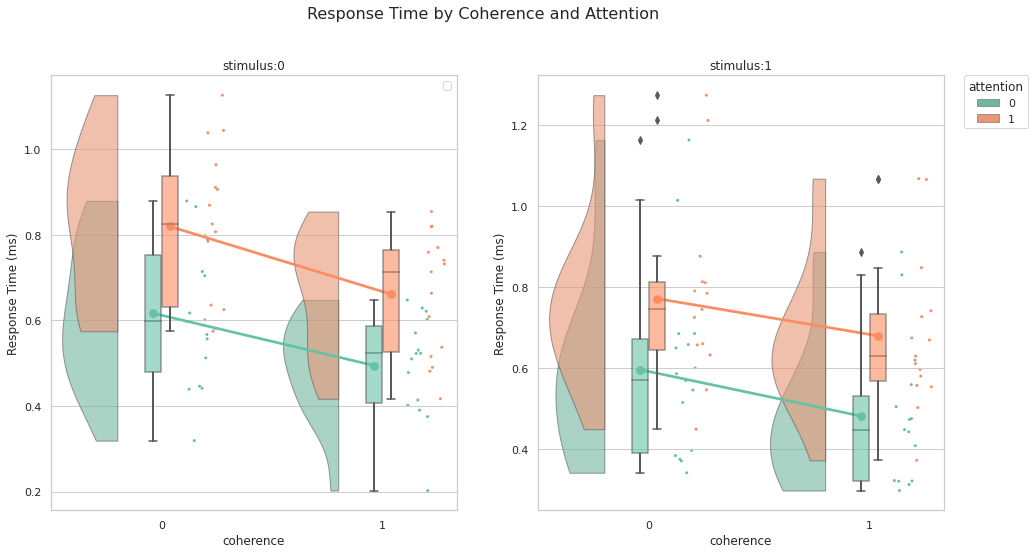

In [8]:
f, ax = plt.subplots(1,2,figsize=(16, 8))
# the left figure
ax[0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0].legend('')
ax[0].set_title('stimulus:0')
ax[0].set_ylabel('Response Time (ms)')
# the right figure
ax[1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1].set_title('stimulus:1')
ax[1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

## ANOVA

In [235]:
# ANOVA for rt
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                     67.2112 1.0000 14.0000 0.0000
attention                     50.1713 1.0000 14.0000 0.0000
stimulus                       0.1522 1.0000 14.0000 0.7023
coherence:attention            8.6890 1.0000 14.0000 0.0106
coherence:stimulus             0.1945 1.0000 14.0000 0.6659
attention:stimulus           104.9613 1.0000 14.0000 0.0000
coherence:attention:stimulus  64.9475 1.0000 14.0000 0.0000

                          Anova
                             F Value Num DF  Den DF Pr > F
----------------------------------------------------------
coherence                    19.3015 1.0000 14.0000 0.0006
attention                    52.3731 1.0000 14.0000 0.0000
stimulus                      7.4916 1.0000 14.0000 0.0160
coherence:attention          36.0000 1.0000 14.0000 0.0000
coherence:stimulus            2.9787 1.0

## fit data

### define the model

In [18]:
 def ms2(id, df=None, samples=None, burn=None, thin=1,save_name='ms1'):
        '''
        id: the id of cpu thread
        df: the input data
        samples: number of samples for MCMC
        burn: number of burn-in of MCMC
        thin: number of thin
        save_name: prefix of file name when saving the model object
        '''
        print('running chain {:d} for model {}'.format(id, save_name))
        # the database file
        dbname = save_name + '_chain_%i.db'%id
        # the model object store here
        mname = save_name + '_chain_%i'%id
        # define the model
        v_reg = {'model':'v~C(coherence)','link_func':lambda x:x}
        z_reg = {'model':'z~C(attention)','link_func':lambda x:x}
        reg_descr = [v_reg, z_reg]
        m = hddm.HDDMRegressor(df, 
                               reg_descr, 
                               include=['z'],
                               group_only_regressors=False,
                               keep_regressor_trace=True
                               )
        # find the starting point
        m.find_starting_values()
        # MCMC sample
        m.sample(samples, 
                 burn=burn, 
                 thin=thin, 
                 dbname=dbname,
                 db='pickle')
        # save
        m.save(mname)
        
        return m

### judge whether need to sample

In [2]:
%%time
# number of chains
chains=4
# file name
file_names = glob.glob('ms2'+'_chain_*[!db]',recursive=False)
# if there exists file, pass
if file_names:
    # sort filename by id
    file_names = sorted(file_names, key = lambda x:x[-1])
    ms2res = []
    for fname in file_names:
        print('current loading:',fname,'\n')
        ms2res.append(hddm.load(fname))
# else sample
else:
    ms2res = Parallel(n_jobs = 4)(delayed(ms2)(id = i, df = df, samples=4000,burn = 2000,thin=2, save_name = 'ms2' ) for i in range(4))


current loading: ms2_chain_0 

current loading: ms2_chain_1 

CPU times: user 17.9 s, sys: 2.91 s, total: 20.8 s
Wall time: 20.8 s


In [20]:
ms2res = Parallel(n_jobs = 4)(delayed(ms2)(id = i, df = df, samples=2000,burn = 1000,thin=1, save_name = 'ms2' ) for i in range(4))


running chain 0 for model ms2
running chain 1 for model ms2
Adding these covariates:
['v_Intercept', 'v_C(coherence)[T.1.0]']
Adding these covariates:
['v_Intercept', 'v_C(coherence)[T.1.0]']
Adding these covariates:
['z_Intercept', 'z_C(attention)[T.1.0]']
Adding these covariates:
['z_Intercept', 'z_C(attention)[T.1.0]']
running chain 3 for model ms2
running chain 2 for model ms2
Adding these covariates:
['v_Intercept', 'v_C(coherence)[T.1.0]']
Adding these covariates:
['z_Intercept', 'z_C(attention)[T.1.0]']
Adding these covariates:
['v_Intercept', 'v_C(coherence)[T.1.0]']
Adding these covariates:
['z_Intercept', 'z_C(attention)[T.1.0]']


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

[                  0%                  ] 2 of 2000 complete in 1.3 sec
[                  0%                  ] 2 of 2000 complete in 1.3 sec
[                  0%                  ] 2 of 2000 complete in 1.3 sec
[                  0%                  ] 2 of 2000 complete in 1.4 sec
[                  0%                  ] 3 of 2000 complete in 2.7 sec
[                  0%                  ] 3 of 2000 complete in 2.7 sec
[                  0%                  ] 3 of 2000 complete in 2.8 sec
[                  0%                  ] 3 of 2000 complete in 3.1 sec
[                  0%                  ] 4 of 2000 complete in 4.1 sec
[                  0%                  ] 4 of 2000 complete in 4.2 sec
[                  0%                  ] 4 of 2000 complete in 4.4 sec
[                  0%                  ] 4 of 2000 complete in 4.7 sec
[                  0%                  ] 5 of 2000 complete in 5.6 sec
[                  0%                  ] 5 of 2000 complete in 5.7 sec
[     

### convert hddm model object to Inferencedata    

In [ ]:
file_names = glob.glob('infdata_ms2_netcdf',recursive=False)
if file_names:
    infdata_ms2 = az.from_netcdf('infdata_ms2_netcdf')
else:
    InfData_ms2 = InferenceDataFromHDDM(ms2res, nppc = 300, save_name="infdata_ms2")

## visualization

### plot traces

In [ ]:
az.plot_trace(InfData_ms2, 
              var_names=("^v(?!.*(subj|std))"), 
              filter_vars='regex')

In [ ]:
az.plot_trace(InfData_ms2, 
              var_names=("^z(?!.*(subj|std))"), 
              filter_vars='regex')

### summary data

In [ ]:
ms2_summary_tmp = az.summary(InfData_ms2, round_to=4)
ms2_summary_tmp.sort_values('r_hat')

### posterior predictive check

In [ ]:
az.plot_ppc(InfData_ms2,
            var_names=['rt','response'], 
            textsize=20, 
            num_pp_samples=300, 
            alpha = 0.2)

### Check dic, loo and waic

In [3]:
# dic
m2 = kabuki.utils.concat_models(ms2res)
m2.dic

-1589.737085887929

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(coherence)[T.1.0]
Plotting v_C(coherence)[T.1.0]_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(attention)[T.1.0]
Plotting z_C(attention)[T.1.0]_std


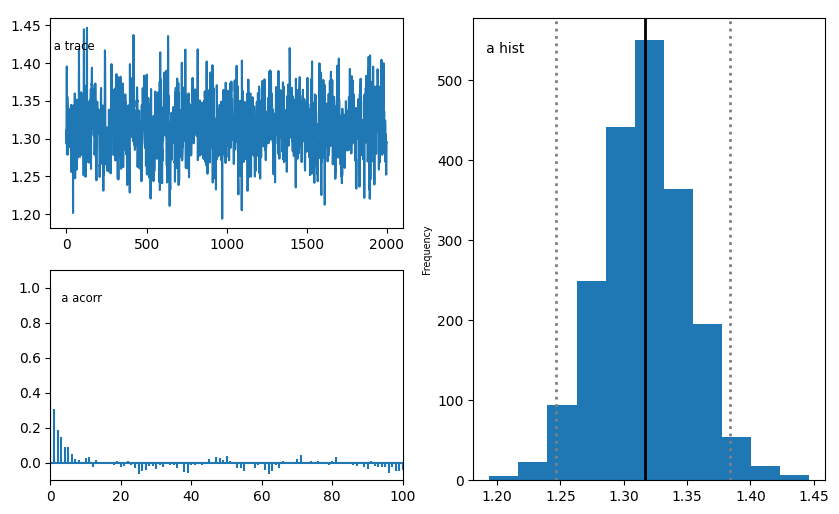

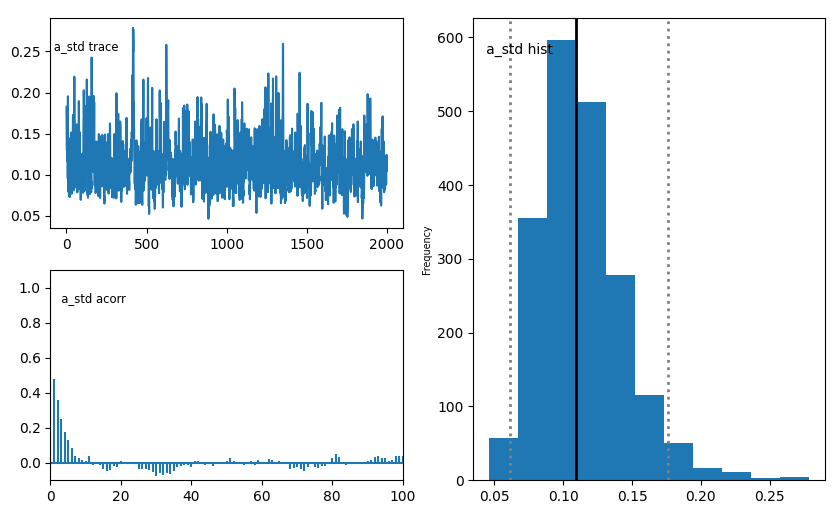

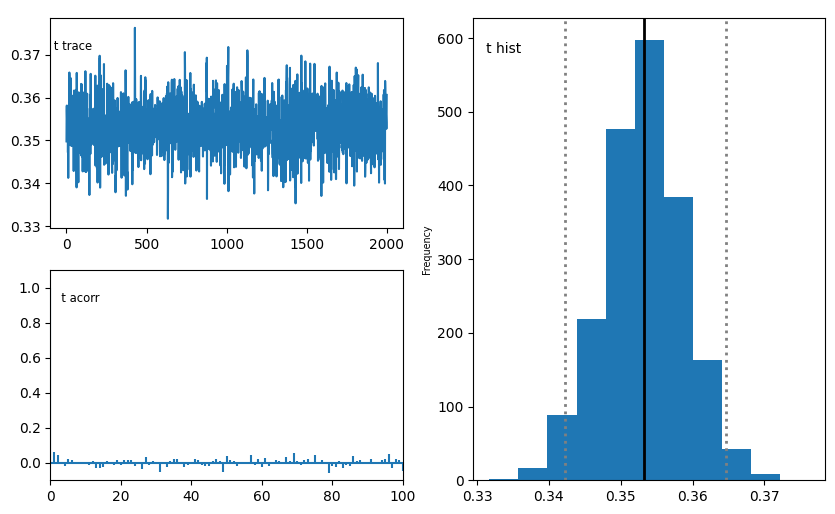

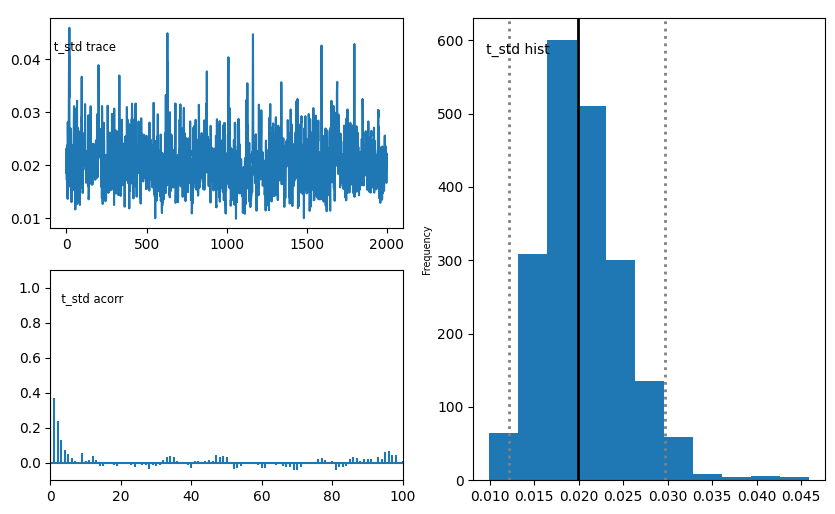

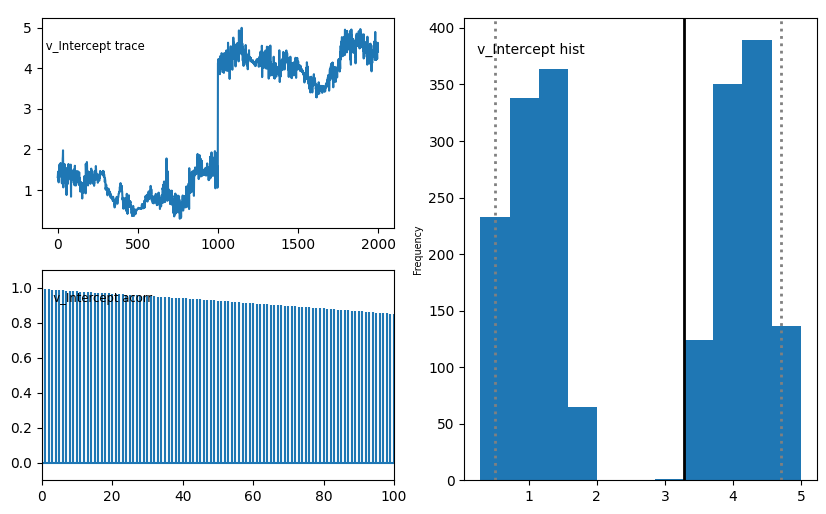

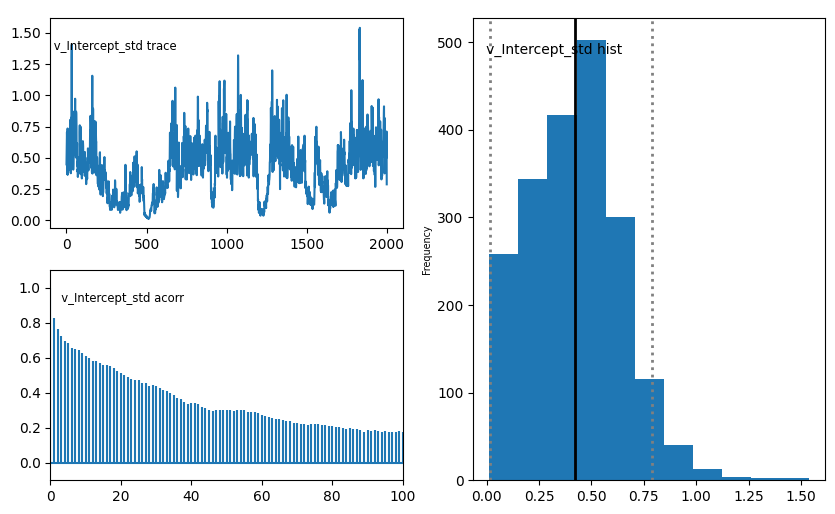

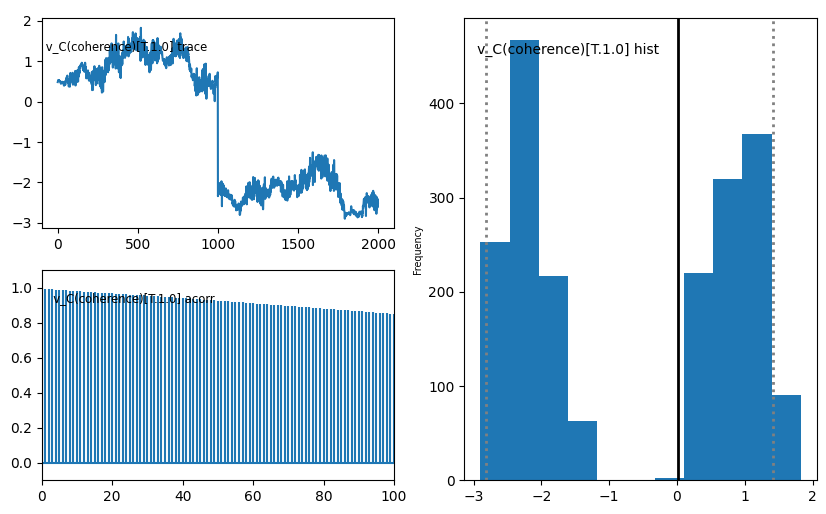

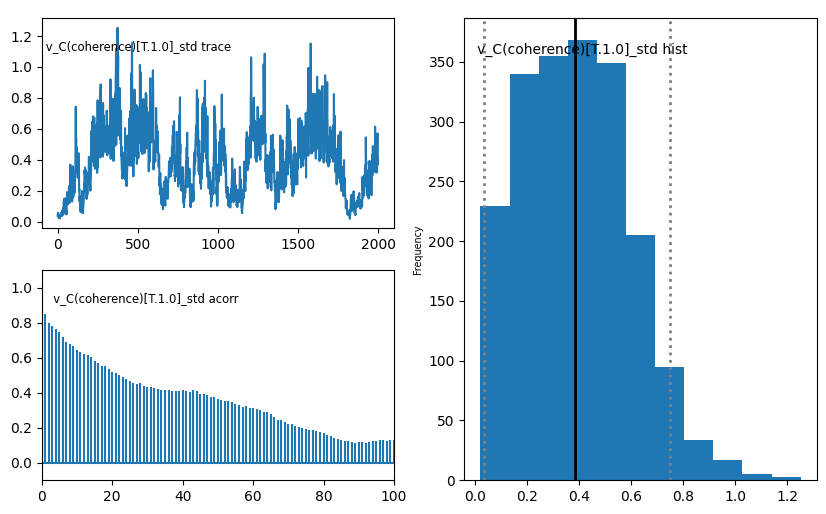

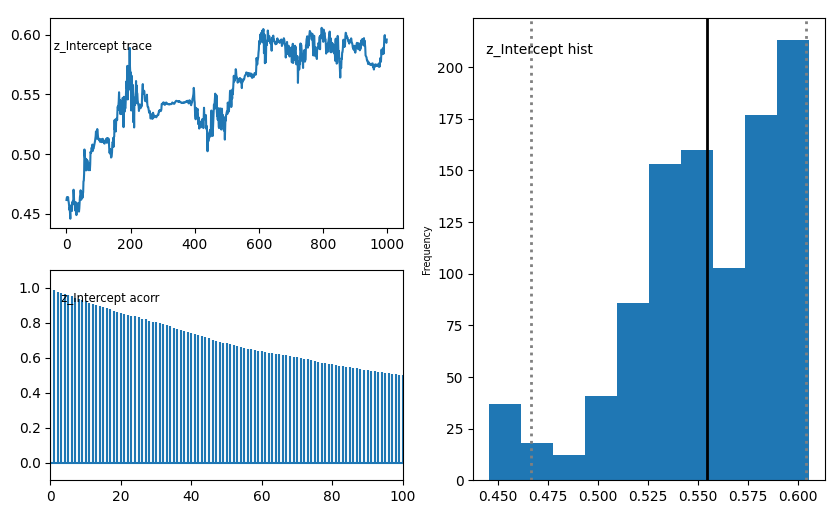

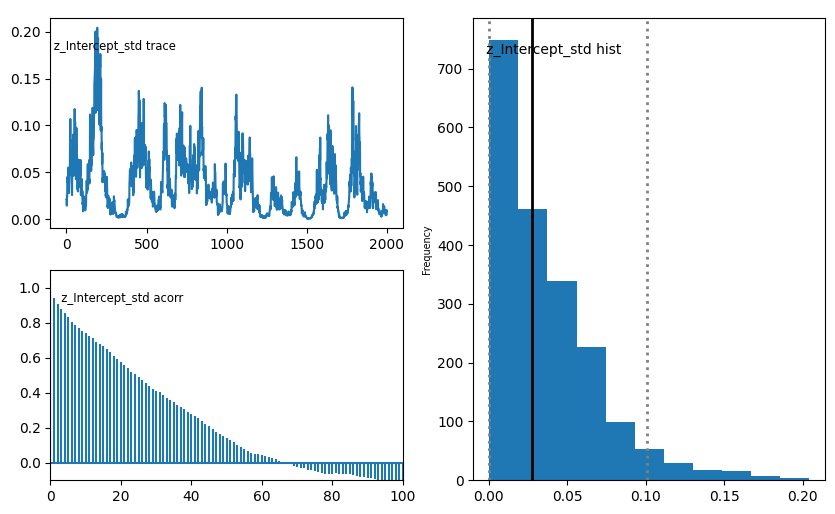

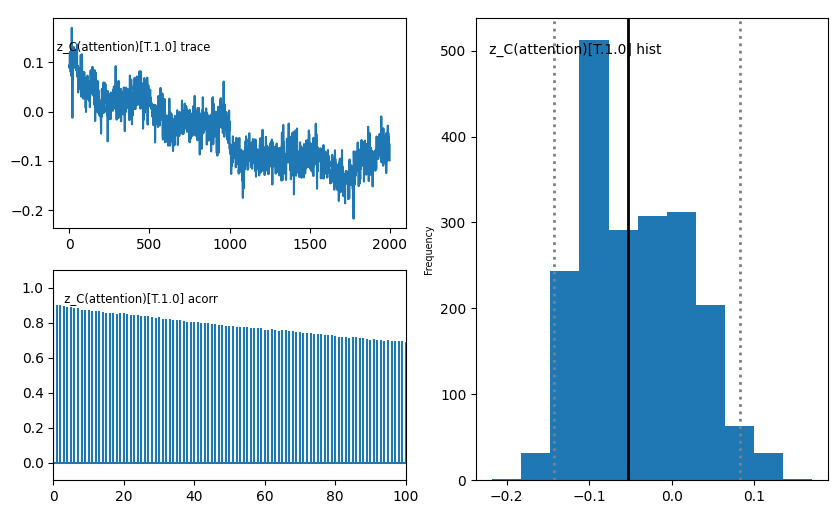

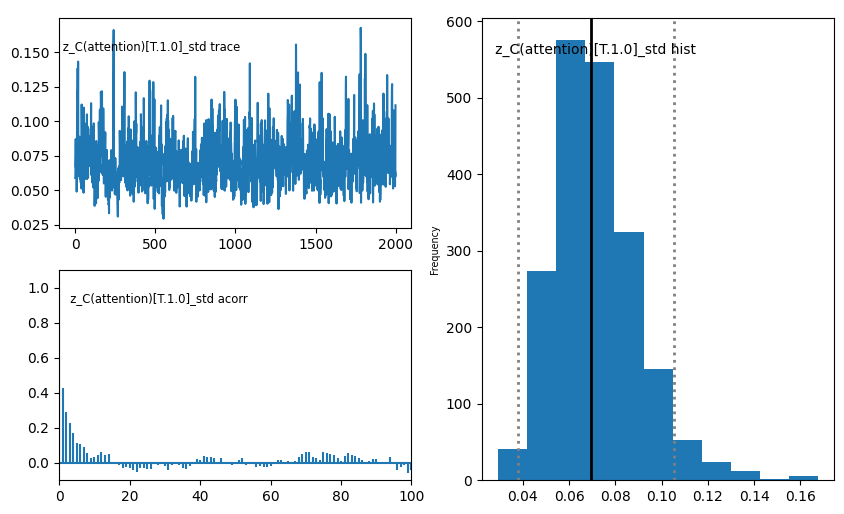

In [4]:
m2.plot_posteriors()

In [ ]:
# loo
az.loo(InfData_ms2, scale="deviance")

In [ ]:
# waic
az.waic(InfData_ms2, scale="deviance")

### posterior predictive check by condition

In [ ]:
# coherence
plot_ppc_by_cond(data = InfData_ms2, 
                 or_d = df, 
                 subjs = [3], 
                 conds = ['coherence'], 
                 num_pp_samples=300, 
                 random_seed = 7, 
                 alpha = 0.2, 
                 grid = [2,2], 
                 textsize=20, 
                 var_names=['rt'])

In [ ]:
# attention
plot_ppc_by_cond(data = InfData_ms2, 
                 or_d = df, 
                 subjs = [3], 
                 conds = ['attention'], 
                 num_pp_samples=300, 
                 random_seed = 7, 
                 alpha = 0.2, 
                 grid = [2,2], 
                 textsize=20, 
                 var_names=['rt'])

## Statistical Inference

In [ ]:
az.plot_posterior(InfData['ms2'], 
                  filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|Intercept))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=v_int)

In [ ]:
az.plot_posterior(InfData['ms2'], 
                  filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|coherence))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=v_coh)

In [ ]:
# z_int
az.plot_posterior(InfData['ms2'], 
                  filter_vars='regex', 
                  var_names=("^z_(?!.*(subj|std|Intercept))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=t_int)

In [ ]:
# z_coh
az.plot_posterior(InfData['ms2'], 
                  filter_vars='regex', 
                  var_names=("^z_(?!.*(subj|std|attention))"), 
                  kind='hist', 
                  hdi_prob=0.95,
                  ref_val=t_pri)